In [1]:
import pandas as pd

df = pd.concat((
    pd.read_csv('./data/October_missions_full.csv'),
    pd.read_csv('./data/November_1stW_missions_full.csv')
), ignore_index=True)

df['mission'] = df['type'] + '_' + df['target'].astype(str)

df = df[['user', 'mission', 'createdAtT', 'type', 'target', 'performance']]
df['createdAtT'] = pd.to_datetime(df['createdAtT'], unit='ms').dt.date
df = df.groupby('user').filter(lambda x: len(x['createdAtT'].unique()) > 1)

df['user'] = df['user'].astype('category').cat.codes
df['mission'] = df['mission'].astype('category')
df['missionID'] = df['mission'].cat.codes
df['type'] = df['type'].astype('category')

def reward(x):
    if x <= 1:
        return x
    return 2 - x**2

df['reward'] = df['performance'].apply(reward)
df.rename(columns={'createdAtT': 'date'}, inplace=True)

df.sort_values(by=['date', 'user'], inplace=True, ignore_index=True)
df

,user,mission,date,type,target,performance,missionID,reward
0,0,episode_2,2024-10-01,episode,2,0.000000,13,0.000000
1,0,action_2,2024-10-01,action,2,0.000000,1,0.000000
2,0,episode_1,2024-10-01,episode,1,1.000000,12,1.000000
3,0,quiz_1,2024-10-01,quiz,1,1.000000,24,1.000000
4,0,quiz_4,2024-10-01,quiz,4,1.000000,27,1.000000
...,...,...,...,...,...,...,...,...
93879,2960,activity_7,2024-11-07,activity,7,0.000000,9,0.000000
93880,2960,quiz_1,2024-11-07,quiz,1,0.000000,24,0.000000
93881,2968,mobility_3,2024-11-07,mobility,3,0.000000,22,0.000000
93882,2968,quiz_3,2024-11-07,quiz,3,0.333333,26,0.333333


In [2]:
n_users = df['user'].nunique()
n_missions = df['mission'].nunique()

n_users, n_missions

(2969, 31)

In [3]:
from src.tree import TreeNode

missions = df[['missionID', 'type', 'target']].drop_duplicates()
root = TreeNode('root')
for name, round in missions.groupby('type', observed=True):
    node = TreeNode(name)
    root.add_child(node)
    for _, mission in round.iterrows():
        node.add_child(TreeNode(mission.to_dict()))

print(root)

root
	action
		{'missionID': 1, 'type': 'action', 'target': 2}
		{'missionID': 0, 'type': 'action', 'target': 1}
	activity
		{'missionID': 11, 'type': 'activity', 'target': 9}
		{'missionID': 10, 'type': 'activity', 'target': 8}
		{'missionID': 7, 'type': 'activity', 'target': 5}
		{'missionID': 2, 'type': 'activity', 'target': 1}
		{'missionID': 3, 'type': 'activity', 'target': 10}
		{'missionID': 9, 'type': 'activity', 'target': 7}
		{'missionID': 5, 'type': 'activity', 'target': 3}
		{'missionID': 8, 'type': 'activity', 'target': 6}
		{'missionID': 6, 'type': 'activity', 'target': 4}
		{'missionID': 4, 'type': 'activity', 'target': 2}
	episode
		{'missionID': 13, 'type': 'episode', 'target': 2}
		{'missionID': 12, 'type': 'episode', 'target': 1}
		{'missionID': 16, 'type': 'episode', 'target': 5}
		{'missionID': 17, 'type': 'episode', 'target': 6}
		{'missionID': 15, 'type': 'episode', 'target': 4}
		{'missionID': 14, 'type': 'episode', 'target': 3}
	exp
		{'missionID': 18, 'type': 

In [4]:
from src import policy as pol
from src import models as mod
from src.tree import TreeBandit
from tqdm.auto import tqdm

def replay(df: pd.DataFrame, policy: pol.Policy, root: TreeNode):
    history = pd.DataFrame()
    tree_bandit = TreeBandit(root, policy)
    for _, round in tqdm(df.groupby('date')):
        day_recs = []
        for u in tqdm(round['user'].unique(), leave=False):
            policy.init()
            recs = [{'user': u, 'missionID': m.value['missionID']} for m in tree_bandit.select(n = (3, 1), user=u)]
            day_recs += recs

        actions = round.merge(pd.DataFrame(day_recs), on=['user', 'missionID'], how='inner')
        history = pd.concat((history, actions), ignore_index=True)
        policy.update(train_df=history)
            
    return history

In [5]:
def evaluate(policy) -> pd.DataFrame:
    rewards = replay(df[['user', 'missionID', 'date', 'reward', 'performance']], policy, root)
    rewards = rewards.groupby('date')['reward'].sum().cumsum()

    return rewards

In [ ]:
import torch
import numpy

torch.manual_seed(0)
numpy.random.seed(0)

policies = {
    'Random':           pol.RandomBandit(),
    'Epsilon-Greedy':   pol.MeanEpsilonGreedy(epsilon=0.1),
    'MF':               pol.ModelEpsilonGreedy(model=mod.MissionMatrixFactorization(n_users, n_missions, embedding_dim=8), epsilon=0),
    'Softmax-MF':       pol.SoftmaxBandit(model=mod.MissionMatrixFactorization(n_users, n_missions, embedding_dim=8)),
    'Epsilon-Greedy-MF':pol.ModelEpsilonGreedy(model=mod.MissionMatrixFactorization(n_users, n_missions, embedding_dim=8), epsilon=0.1),
}

results = pd.concat([
    pd.concat({name: evaluate(policy) for name, policy in tqdm(policies.items())})
    for _ in tqdm(range(5))
], axis=1)

results

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

  0%|          | 0/687 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/791 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/698 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

  0%|          | 0/687 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/791 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/698 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

  0%|          | 0/687 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/791 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/698 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

  0%|          | 0/687 [00:00<?, ?it/s]

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/791 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/797 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/698 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

reward
           date                   
Random     2024-10-01   137.861667
           2024-10-02   251.704762
           2024-10-03   356.675595
           2024-10-04   444.299722
           2024-10-05   535.720556
...                            ...
Softmax-MF 2024-11-03  3187.153730
           2024-11-04  3271.928730
           2024-11-05  3361.235397
           2024-11-06  3452.002778
           2024-11-07  3558.632500

[152 rows x 1 columns]

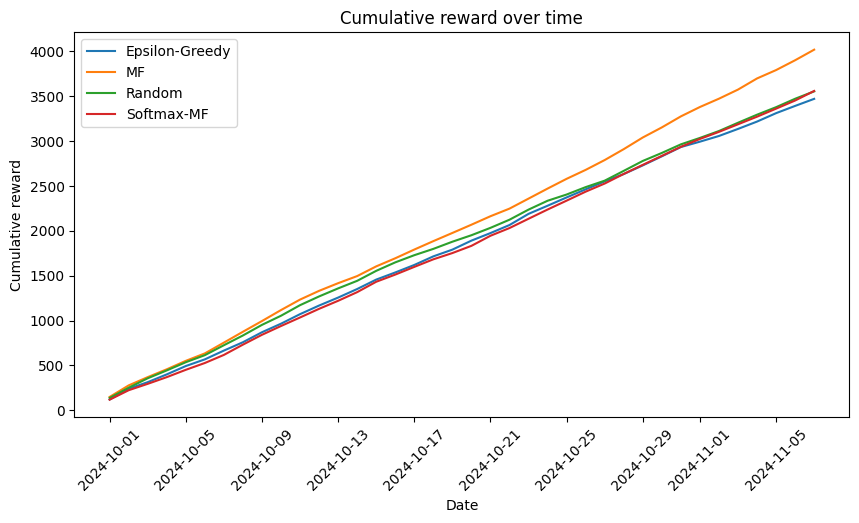

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
for name, group in results.groupby(level=0):
    plt.plot(group.index.get_level_values(1), group.mean(axis=1), label=name)
    plt.fill_between(group.index.get_level_values(1), group.mean(axis=1) - group.std(axis=1), group.mean(axis=1) + group.std(axis=1), alpha=0.2)

plt.title('Cumulative reward over time')
plt.ylabel('Cumulative reward')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.show()